In [1]:
from __future__ import print_function
import os
from skimage.transform import resize
from skimage.io import imsave
from skimage import img_as_ubyte
import numpy as np
from skimage.segmentation import mark_boundaries,join_segmentations
from keras.models import Model,Sequential
from tensorflow.keras.layers import *
from keras.layers import Input, Conv2D, MaxPooling2D , Conv2DTranspose ,Dropout, UpSampling2D, Dense
from keras.layers.core import Lambda, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers.normalization import BatchNormalization 
from keras import backend as K
from skimage.exposure import rescale_intensity
from keras.callbacks import History
from skimage import io
import nibabel
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

In [2]:
K.set_image_data_format('channels_last')  

img_rows = int(512/2)
img_cols = int(512/2)
smooth = 1.


In [3]:
def load_train():
    imgs_train = np.load('/content/drive/MyDrive/tez/ircad-numpy/imgs_train.npy')
    masks_train = np.load('/content/drive/MyDrive/tez/ircad-numpy/masks_train.npy')
    return imgs_train, masks_train

In [4]:
def load_test():
    imgs_test = np.load('/content/drive/MyDrive/tez/ircad-numpy/imgs_test.npy')
    return imgs_test

In [5]:

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
    

In [6]:
#Veriseti boyutunu değiştirme
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p


In [7]:
def fcn():
    img_input = Input((img_rows, img_cols, 1))
  
    #1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    block_1_out = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(block_1_out)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    block_2_out = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(block_2_out)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    # x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    block_3_out = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)


    #4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(block_3_out)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    
    # x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    block_4_out = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
  

    #5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(block_4_out)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    x = Conv2D(4096, (7, 7), padding='same',activation="relu")(x)
    x = Dropout(0.5)(x)

    x = Conv2D(4096, (1, 1), padding='same',activation="relu")(x)
    x = Dropout(0.5)(x)

    x = Conv2D(2, (1, 1), strides=(1, 1))(x)

    block_3_out = Conv2D(2, (1, 1), strides=(1, 1),activation='relu')(block_3_out)

    block_4_out = Conv2D(2, (1, 1), strides=(1, 1),activation='relu')(block_4_out)

    block_5_out = Conv2DTranspose(2, (4, 4), strides=(2,2), padding='same',activation='relu', name='deconv1')(x)
    merge1=add([block_4_out,block_5_out])
    merge1_deconv=Conv2DTranspose(2, (4, 4), strides=(2,2), padding='same',activation='relu', name='deconv2')(merge1)

    merge2=add([block_3_out,merge1_deconv])
    outputs=Conv2DTranspose(2, (16, 16), strides=(8,8), padding='same', name='deconv3')(merge2)
    

    outputs = Activation('softmax')(outputs)
    
    model = Model(img_input,outputs)
    model.compile(optimizer=Adam(lr=1e-3),loss=dice_coef_loss, metrics=[dice_coef])
  
    model.summary()
    return model
    

In [8]:
def train():
    print('-/'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = load_train()
    print('-/'*30)

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)
    std = np.std(imgs_train)

    imgs_train -= mean
    imgs_train /= std
    #Normalizasyon
    imgs_mask_train = imgs_mask_train.astype('float32')
   
    print('*'*30)
    print('Creating and compiling model...')
    print('*'*30)
    model=fcn()
    model_checkpoint =[EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)]
    history=model.fit(imgs_train, to_categorical(imgs_mask_train), batch_size=10 , epochs=20, verbose=1, shuffle=True ,validation_split=0.2,callbacks=[model_checkpoint])
  
    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    return model , history , mean , std
    

In [9]:
def predict():
    model, history, mean, std=train()
    print('*'*30)
    print('Loading and preprocessing test data...')
    print('*'*30)
    imgs_test = load_test()
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std
    imgs_test=imgs_test

    print('*'*30)
    print('Loading saved weights...')
    print('*'*30)
    model.load_weights('weights.h5')


    print('Predicting masks on test data...')
    print('*'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    pred ='pred_1'
    if not os.path.exists(pred):
        os.mkdir(pred)

    for k in range(len(imgs_mask_test)):
        a=rescale_intensity(imgs_test[k][:,:,0],out_range=(-1,1)) #yeniden ölçeklendirme
        b=(imgs_mask_test[k][:,:,0]).astype('uint8')
        io.imsave(os.path.join(pred, str(k) + '_pred.png'),mark_boundaries(a,b))

    plt.figure(figsize=(15, 15))
    plt.suptitle('Training Statistics on Train Set')

    plt.subplot(2,1,1)
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('Model dice coef')
    plt.ylabel('Dice coef')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

    plt.subplot(2,1,2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Training","Validation"])
    plt.show()
    

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/
Loading and preprocessing train data...
------------------------------
-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/
******************************
Creating and compiling model...
******************************
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         block1_conv1[0][0]               
_____

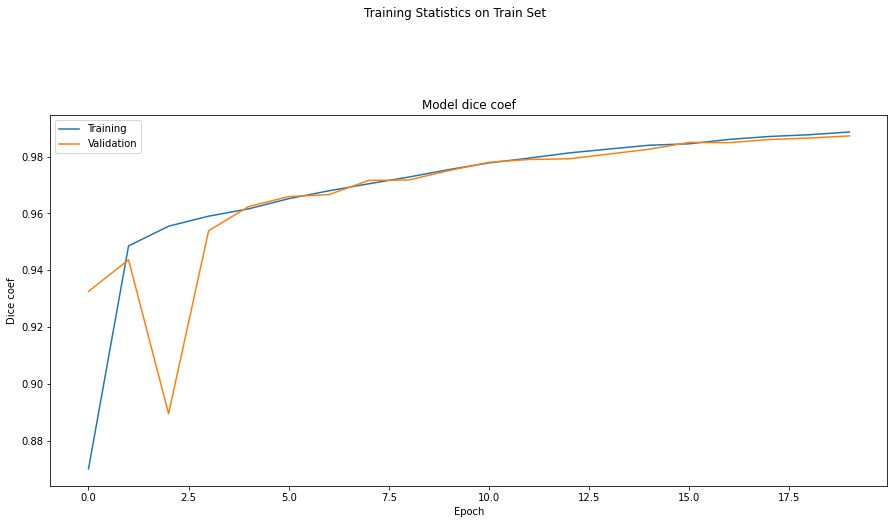

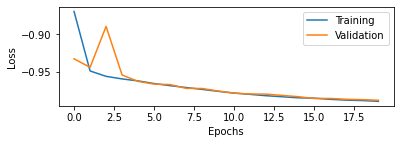

In [11]:
if __name__ == '__main__':
    predict()
